# Automatic NMR integration
This notebook shows an example of the code used for the automatic acquisition of F-NMR spectra and their integration.

In [8]:
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from flowchem.components.devices.Magritek import Spinsolve, NMRSpectrum
from flowchem import Knauer16PortValve

In [ ]:
# Acquisition and integration settings

# set the wait time between two NMR measurement 
NMR_DELAY = 60 * 2  # in sec
counter = it.count()

# set the integration limits (in ppm)
peak_list = np.array(
    [['SM', -60.85, -61.1 ],
     ['Product', -61.1 , -61.35],
     ['Side-P', -60.5 , -60.7 ]]
)

In [ ]:
async def Analysis(observed_result):
    nmr = Spinsolve(host="BSMC-YMEF002121")

    while True:
        path = await nmr.run_protocol(
            "1D FLUORINE+",
            {
                "Number": 128,
                "AcquisitionTime": 3.2,
                "RepetitionTime": 2,
                "PulseAngle": 90,
            },
        )
        observed_time = (NMR_DELAY / 60 + 4) * next(counter)

        peak_normalized_list = peak_aquire_process(path)
        observed_result = observed_result.append(
            pd.DataFrame(
                peak_normalized_list,
                index=["SM", "product", "side-P"],
                columns=[observed_time],
            ).T
        )

        # Print results
        print(observed_result)
        
        # save to CSV
        observed_result.to_csv(
            r"W:\BS-FlowChemistry\People\Wei-Hsin\Spinsolve\dataframe_0317_03.csv",
            header=True,
        )
        
        plt.figure()
        observed_result.plot()
        plt.legend(loc="best")
        plt.savefig(
            r"W:\BS-FlowChemistry\People\Wei-Hsin\Spinsolve\plot_0317_03.png"
        )

        await asyncio.sleep(NMR_DELAY)

In [ ]:
def peak_aquire_process(path):
    spectrum = NMRSpectrum(path)
    spectrum.process()

    peak_sum_list = []

    # loop over the integration limits
    for name, start, end in peak_list:
        min = spectrum.uc(start, "ppm")
        max = spectrum.uc(end, "ppm")
        if min > max:
            min, max = max, min
        # extract the peak
        peak = spectrum.processed_data[min : max + 1]
        peak_sum_list.append(peak.sum())

    # peak normalization
    y = sum(peak_sum_list)
    peak_normalized_list = [i / y for i in peak_sum_list]
    return peak_normalized_list

In [ ]:
async def main():
    observed_time = 0
    observed_result = pd.DataFrame(
        [1, 0, 0], index=["SM", "product", "side-P"], columns=[observed_time]
    ).T
    await Analysis(observed_result)


if __name__ == "__main__":
    asyncio.run(main())

## Example results
A panda dataframe from an experiment is used to show examplary results.

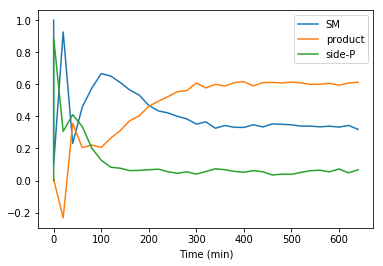

In [7]:
%matplotlib inline
result_file = r"220405_in-line_whhsu044_rate10uLmin_50_02.csv"
df = pd.read_csv(result_file)

df.plot(x=0, xlabel= 'Time (min)')